## All the metrics that are relevant for the Phillips 2 Layer simulations

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

from dask.diagnostics import ProgressBar

import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [3]:
T5 = 36*10
T10 = 36*40
Twindow = slice(T5, T10)

In [4]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Phillips2Layer/res4km_sponge10day_long.zarr').isel(Time=Twindow).isel(xq=slice(0, -1))

In [5]:
ds_200km = xr.open_zarr('gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/res4km_sponge10day_long_ml_data_200km.zarr').isel(Time=Twindow)

### Mean state 

In [6]:
ds_mean = ds[['h','e','v']].mean(['Time','xh'])
ds_200_mean = ds_200km[['h','e','v']].mean(['Time','xh'])

(0.0, 1600.0)

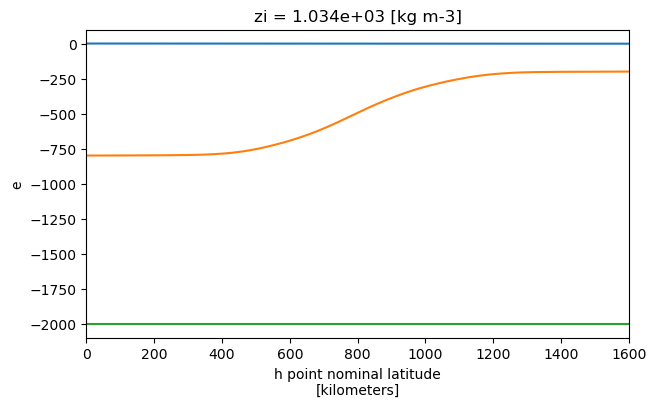

In [7]:
plt.figure(figsize=(7, 4))

ds_mean.e.isel(zi=0).plot()
ds_mean.e.isel(zi=1).plot()
ds_mean.e.isel(zi=2).plot()

plt.xlim([0, 1600])

(0.0, 1600.0)

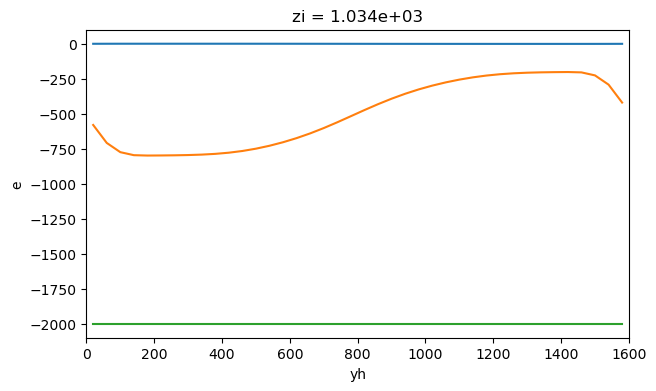

In [8]:
plt.figure(figsize=(7,4))

ds_200_mean.e.isel(zi=0).plot()
ds_200_mean.e.isel(zi=1).plot()
ds_200_mean.e.isel(zi=2).plot()

plt.xlim([0, 1600])

(0.0, 1600.0)

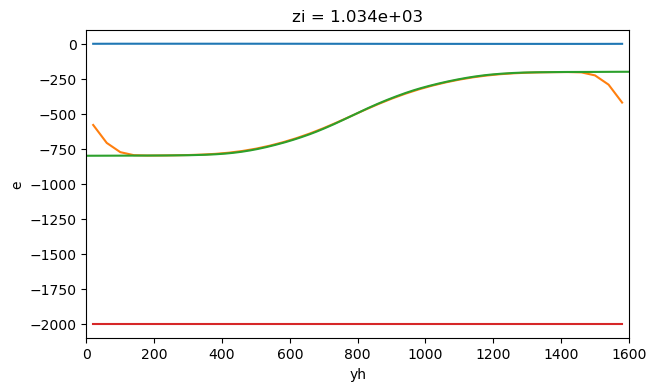

In [9]:
plt.figure(figsize=(7,4))

ds_200_mean.e.isel(zi=0).plot()
ds_200_mean.e.isel(zi=1).plot()
ds_mean.e.isel(zi=1).plot()
ds_200_mean.e.isel(zi=2).plot()

plt.xlim([0, 1600])

## Overturning 

In [10]:
def overturning_HR(ds, load=True): 
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])

    
    vmean = xgrid.interp(ds.v.mean(['Time','xh']), 'Y', boundary='extend')
    hmean = ds.h.mean(['Time','xh'])

    OT_mean = vmean*hmean

    OT_eddy = ( ( xgrid.interp(ds.v, 'Y', boundary='extend') - vmean)*(ds.h-hmean) ).mean(['Time','xh'])

    if load: 
        OT_mean.load()
        OT_eddy.load() 
    return OT_mean, OT_eddy    

In [11]:
def overturning_filtered(ds, load=True): 

    vmean = ds.v.mean(['Time','xh'])
    hmean = ds.h.mean(['Time','xh'])

    OT_mean = vmean*hmean

    OT_eddy = ( ( ds.v - vmean)*(ds.h-hmean) ).mean(['Time','xh'])

    OT_res = ds.vbar_hbar.mean(['Time','xh'])

    OT_sg = ds.vh_sg.mean(['Time','xh'])

    if load: 
        OT_mean.load()
        OT_eddy.load() 
        OT_res.load()
        OT_sg.load()
    return OT_mean, OT_eddy, OT_sg, OT_res

In [13]:
OT_mean, OT_eddy = overturning_HR(ds)

In [14]:
OT_200_mean, OT_200_eddy, OT_200_sg, OT_200_res = overturning_filtered(ds_200km, load=True)

(-1.0, 12.0)

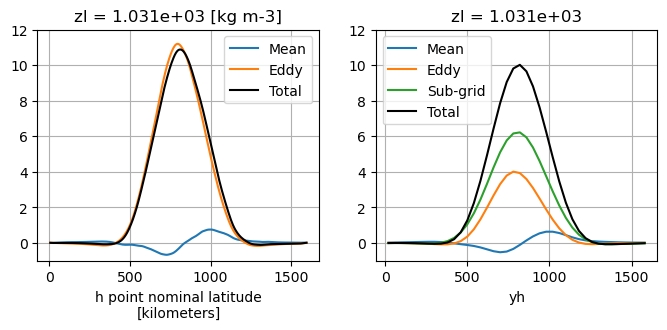

In [16]:
plt.figure(figsize=(8,3))

plt.subplot(121)
OT_mean.isel(zl=0).plot(label='Mean')
OT_eddy.isel(zl=0).plot(label='Eddy')
(OT_mean + OT_eddy).isel(zl=0).plot(label='Total', color='k')
plt.legend()
plt.ylim(-1, 12)
plt.grid()

plt.subplot(122)
OT_200_mean.isel(zl=0).plot(label='Mean')
OT_200_eddy.isel(zl=0).plot(label='Eddy')
OT_200_sg.isel(zl=0).plot(label='Sub-grid')
#OT_200_res.isel(zl=0).plot(label='Resolved')
(OT_200_mean + OT_200_eddy + OT_200_sg).isel(zl=0).plot(label='Total', color='k')
plt.legend()
plt.grid()
plt.ylim(-1, 12)

Slight underestimate of total in the filtered/coarsened setup is likely coming from the fact that we did not account for the eddy part that comes from the coarsening. 

### Flux divergence 

In [29]:
def flux_div_HR(ds, load=True):
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])

    uh = ds.u * xgrid.interp(ds.h,'X') 
    vh = ds.v * xgrid.interp(ds.h,'Y', boundary='extend')

    uh_x = xgrid.diff(uh, 'X')/xgrid.diff(ds.xq*1e3, 'X')
    vh_y = xgrid.diff(vh, 'Y', boundary='extend')/xgrid.diff(ds.yq*1e3,'Y', boundary='extend')

    return (uh_x + vh_y).mean(['Time','xh'])

In [148]:
ds_200km

<xarray.Dataset>
Dimensions:    (Time: 1080, zl: 2, yh: 40, xh: 30, zi: 3)
Coordinates:
  * Time       (Time) object 0010-11-20 00:00:00 ... 0040-06-05 00:00:00
  * xh         (xh) float64 20.0 60.0 100.0 140.0 ... 1.1e+03 1.14e+03 1.18e+03
  * yh         (yh) float64 20.0 60.0 100.0 140.0 ... 1.5e+03 1.54e+03 1.58e+03
  * zi         (zi) float64 1.03e+03 1.032e+03 1.034e+03
  * zl         (zl) float64 1.031e+03 1.033e+03
Data variables: (12/27)
    dudx       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    dudy       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    dvdx       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    dvdy       (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    e          (Time, zi, yh, xh) float32 dask.array<chunksize=(72, 3, 40, 30), meta=np.ndarray>
    h          (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    ...         ...
    vh_bar     (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    vh_sg      (Time, zl, yh, xh) float64 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    vv         (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    vv_bar     (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    vv_sg      (Time, zl, yh, xh) float32 dask.array<chunksize=(72, 2, 40, 30), meta=np.ndarray>
    gr         (zi) float64 9.81 0.01962 0.0

In [35]:
def flux_div_filtered(ds, load=True):

    return 

In [30]:
F_div_HR = flux_div_HR(ds)
F_div_HR.load();

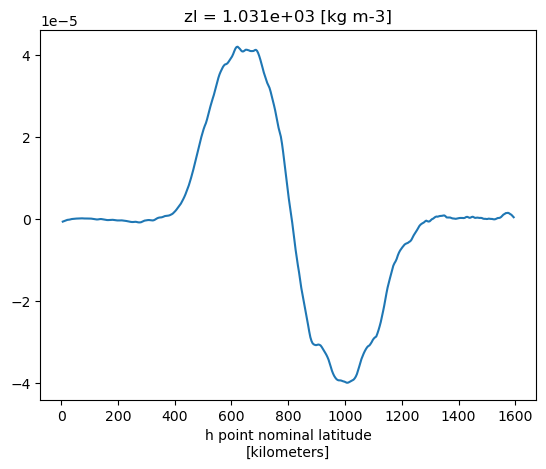

In [33]:
F_div_HR.isel(zl=0).plot()

### KE mean and eddy

In [110]:
def KE_HR(ds):
    xgrid = Grid(ds, coords={'X': {'center': 'xh', 'right': 'xq'},
                             'Y': {'center': 'yh', 'outer': 'yq'},
                             'Z': {'center': 'zl', 'outer': 'zi'} },
                 periodic=['X'])
    
    Umean = ds.u.mean(['Time','xq'])
    Vmean = ds.v.mean(['Time','xh'])
    
    Up = ds.u - Umean
    Vp = ds.v - Vmean
    
    MKE = 0.5*( Umean**2 + xgrid.interp(Vmean,'Y', boundary='extend')**2)
    EKE = 0.5*( xgrid.interp(Up, 'X')**2 + xgrid.interp(Vp,'Y', boundary='extend')**2).mean(['Time','xh'])

    return MKE.mean(['yh','zl']), EKE.mean(['yh','zl'])

In [112]:
MKE_HR, EKE_HR = KE_HR(ds.sel(yh=slice(200, 1400), yq=slice(200, 1400)))

In [113]:
def KE_filtered(ds): 
    Umean = ds.u.mean(['Time','xh'])
    Vmean = ds.v.mean(['Time','xh'])

    Up = ds.u - Umean
    Vp = ds.v - Vmean
    
    MKE = 0.5*( Umean**2 + Vmean**2 )
    EKE = 0.5*( Up**2 + Vp**2 ).mean(['Time','xh'])

    return MKE.mean(['yh','zl']), EKE.mean(['yh','zl'])

In [114]:
MKE_200, EKE_200 = KE_filtered(ds_200km.sel(yh=slice(200, 1400)))

In [115]:
#print(MKE_HR.values, EKE_HR.values)
#print(MKE_200.values, EKE_200.values)

In [146]:
scales =(4, 200)
KE = {"MKE":np.array([MKE_HR.values, MKE_200.values]), 
      "EKE":np.array([EKE_HR.values, EKE_200.values]) }

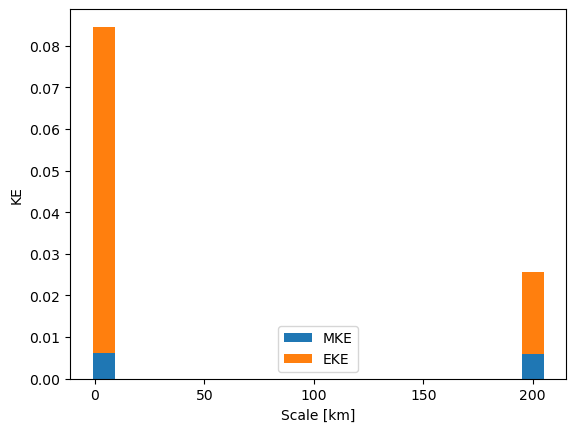

In [147]:
width=10
fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, weight_count in KE.items():
    p = ax.bar(scales, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_xlabel('Scale [km]')
ax.set_ylabel('KE')
ax.legend(loc='lower center')

## PE mean and eddy

In [134]:
def PE_HR(ds): 

    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    eGlobMean = ds.e.mean(['Time','xh','yh'])
    eMean = ds.e.mean(['Time','xh']) - eGlobMean

    PE = (0.5* ds.gr * (ds.e - eGlobMean)**2).sum('zi').mean(['Time','xh','yh'])
    MPE = (0.5* ds.gr * eMean**2).sum('zi').mean(['yh'])
    EPE = PE - MPE

    return MPE, EPE

In [135]:
MPE_HR, EPE_HR = PE_HR(ds.sel(yh=slice(200, 1400), yq=slice(200, 1400)))

In [136]:
MPE_200, EPE_200 = PE_HR(ds_200km.sel(yh=slice(200, 1400)))

In [137]:
print(MPE_HR.values, EPE_HR.values)

531.7225582650985 90.6243114992518


In [138]:
print(MPE_200.values, EPE_200.values)

519.4227039722306 36.42663548819769


In [139]:
PE = {"MPE":np.array([MPE_HR.values, MPE_200.values]), 
      "EPE":np.array([EPE_HR.values, EPE_200.values]) }

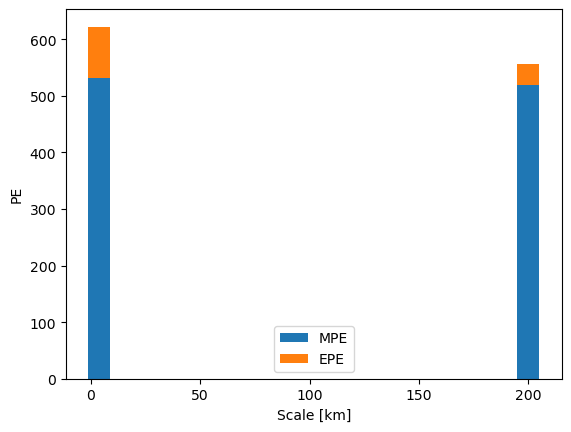

In [144]:
width=10
fig, ax = plt.subplots()
bottom = np.zeros(2)

for boolean, weight_count in PE.items():
    p = ax.bar(scales, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_xlabel('Scale [km]')
ax.set_ylabel('PE')
ax.legend(loc='lower center')

## Sub grid PE transfer spectra

In [168]:
import sys 
sys.path.append('../modules/')

In [169]:
%reload_ext autoreload
%autoreload 2
    
import PE_module

In [163]:
ds_coarse = ds.isel(xq=slice(0, None, 10), yq=slice(0, None, 10) ).coarsen(xh=10,yh=10).mean()
ds_coarse['e'] = ds_200km.e
ds_coarse['Fx'] = ds_200km.uh_sg
ds_coarse['Fy'] = ds_200km.vh_sg

In [164]:
grid_coarse =  Grid(ds_coarse, coords={'X': {'center': 'xh', 'right': 'xq'},
                             'Y': {'center': 'yh', 'outer': 'yq'},
                             'Z': {'center': 'zl', 'outer': 'zi'} },
                 periodic=['X'])

In [165]:
dx=40e3

ds_coarse['divF'] = (grid_coarse.interp(grid_coarse.diff(ds_coarse.Fx, 'X')/dx , 'X') + 
                     grid_coarse.interp(grid_coarse.diff(ds_coarse.Fy, 'Y', boundary='extend')/dx , 'Y', boundary='extend') )

In [174]:
def PE_tend_spectral(ds, var ='divF'): 
    gr = np.zeros(3)
    gr[0] = 9.81
    gr[1] = gr[0] * (ds.zl[1] - ds.zl[0])/ds.zl[0]
    gr[2] = 0.

    ds['gr'] = xr.DataArray(gr, dims={'zi'})

    e_dft = xrft.dft(ds.e, dim='xh', true_phase=True, true_amplitude=True).isel(zi=1)
    var_dft = xrft.dft(ds[var], dim='xh', true_phase=True, true_amplitude=True).isel(zl=1)

    PE_tend_i = (ds.gr * e_dft * np.conjugate(var_dft)).real
    PE_tend = PE_tend_i.sum('zi')
    
    return PE_tend, PE_tend_i

In [175]:
PE_tend, _ = PE_tend_spectral(ds_coarse, var='divF')

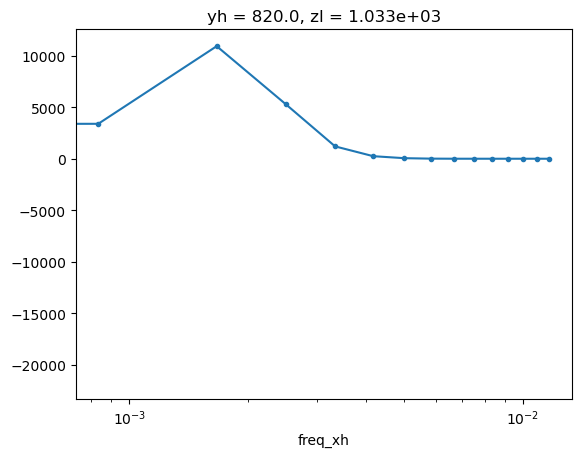

In [182]:
PE_tend.mean('Time').sel(yh=800, method='nearest').plot(marker='.')
plt.xscale('log')
